# 10-5-3 network decay tests

In [575]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
import FFNetwork as FF
import Layer
import importlib
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy
importlib.reload(NN)
importlib.reload(Layer);

In [2]:
def ClassPlot(x, labels=[], idx=(1,2)):
    # FeedForward
    #yc = Network.OneHot(y)
    if len(labels)>0:
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = np.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(x[:,idx[0]], x[:,idx[1]], color=colours, marker='.')
    else:
        plt.scatter(x[:,idx[0]], x[:,idx[1]], marker='.')
    plt.axis('equal');

## Create a simple dataset

In [8]:
# This creates a dataset

n_classes = 3
hidden_dim = 5
sensory_dim = 10

seed = 4896
torch.manual_seed(seed)
np.random.seed(seed)
B = np.eye(n_classes)
X = 3.*(np.random.rand(sensory_dim, n_classes) - 0.5)
A = X.T
print('Bottom vectors')
print(B)
print('Top vectors')
print(A)
#print('System matrix:\n'+str(M))

Bottom vectors
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Top vectors
[[ 2.81545125e-01  4.66284464e-01  1.17578046e+00  2.80777722e-01
  -9.98590398e-01 -1.34068038e+00 -1.22477599e+00 -4.35146799e-01
  -1.00668904e+00  1.22099385e+00]
 [ 1.27140329e+00  7.51001898e-01  6.46658821e-02 -3.09697092e-02
  -1.53034832e-01 -4.57793366e-01  9.34368604e-01  7.71819893e-01
   1.44365010e+00 -9.80089022e-01]
 [ 1.13260480e+00 -1.41664573e+00 -2.49025374e-01 -7.68324958e-01
   5.30640389e-01 -2.12854585e-01  1.14924141e-03 -1.08392019e+00
  -3.72873557e-01  7.83174609e-01]]


In [9]:
# Use A and B to make a dataset
n_classes, top_dim = np.shape(A)
bottom_dim = n_classes

training_samples = 500
noise = 0.2
training_input = []
training_output = []
for n in range(training_samples):
    r = np.random.randint(n_classes)
    training_input.append(B[r])
    training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

training_input = torch.tensor(training_input).float().to(device)
training_output = torch.tensor(training_output).float().to(device)
train = [training_input, training_output]

In [10]:
# Use A and B to make a dataset
def MakeDataset(A, B, n=300, noise=0.2):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes

    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(n_classes)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

In [11]:
train = MakeDataset(A, B)

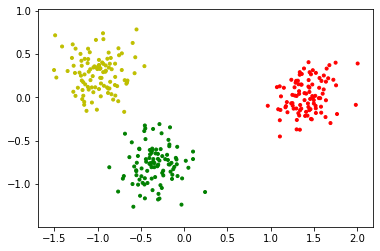

In [12]:
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=(8,3))

## Create a Neural Network

In [253]:
reinitialize = True
iters = 1

In [261]:
if reinitialize:
    v_decay = []
    v_nodecay = []

    net_nodecay = []
    net_decay = []
    
seed = 25
torch.manual_seed(seed)

net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=n_classes))
net.AddLayer(Layer.PELayer(n=hidden_dim))
net.AddLayer(Layer.TopPELayer(n=sensory_dim))

sym = False
af = 'identity'
net.Connect(0, 1, act=af, symmetric=sym)
net.Connect(1, 2, act=af, symmetric=sym)

net.SetTau(0.02)
net.learning_tau = 0.1
net.learn_biases = False
net.learning_blackout=2.0

# Make two copies
net0 = deepcopy(net)
net1 = deepcopy(net)
net2 = deepcopy(net)

for k in range(iters):
    train = MakeDataset(A, B, n=500)

    net0.SetWeightDecay(0.0)
    net0.SetvDecay(0.)
    #net0.Learn(train[0], train[1], T=5., dt=0.001, epochs=10, batch_size=20)
    
    net1.SetWeightDecay(0.02)
    net1.SetvDecay(0.01)
    net1.Learn(train[0], train[1], T=5., dt=0.001, epochs=10, batch_size=20)
    
    net2.SetWeightDecay(0.02)
    net2.SetvDecay(0.0)
    net2.Learn(train[0], train[1], T=5., dt=0.001, epochs=10, batch_size=20)

identity
identity


FloatProgress(value=0.0, max=5000.0)

FloatProgress(value=0.0, max=5000.0)

# Test With Activity Decay Applied During Input Generation

In [369]:
classes = np.eye(3)
print(classes)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Text(0.5, 1.0, 'Activity Decay Applied During Generation')

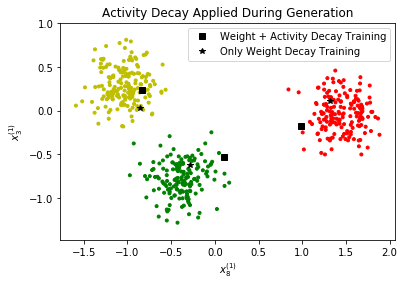

In [572]:
net0.Allocate(classes)
net1.Allocate(classes)
net2.Allocate(classes)

net0.Reset()
net0.SetvDecay(0.01)
net1.Reset()
net1.SetvDecay(0.01)
net2.Reset()
net2.SetvDecay(0.01)

generated_z2s = []
generated_z3s = []

trials = 1
for i in range (0, trials):

    for l in range(0, len(net0.layers)):
        net1.layers[l].v = torch.randn_like(net0.layers[l].v).float().to(device)
        net2.layers[l].v = deepcopy(net0.layers[l].v)
    
    z2 = net1.Predict(10., torch.tensor(classes).float().to(device), dt=0.001)
    z3 = net2.Predict(10., torch.tensor(classes).float().to(device), dt=0.001)

    generated_z2s.append(z2)
    generated_z3s.append(z3)
    
lgnd = ['Weight + Activity Decay Training', 'Only Weight Decay Training'] #['NoWD NoAD', 'YesWD NoAD', 'YesWD YesAD']

idx=(8,3)
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=idx)

plt.plot(np.array(z2[:,idx[0]].cpu()), np.array(z2[:,idx[1]].cpu()), 'ks');
plt.plot(np.array(z3[:,idx[0]].cpu()), np.array(z3[:,idx[1]].cpu()), 'k*');
plt.xlabel('$x_8^{(1)}$')
plt.ylabel('$x_3^{(1)}$')
plt.legend(lgnd)
plt.title('Activity Decay Applied During Generation')

In [567]:
np.save('z2.npy', z2.cpu())
np.save('z3.npy', z3.cpu())

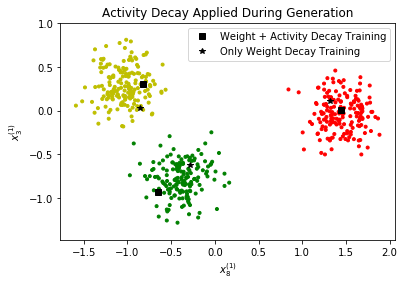

In [481]:
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=idx)
plt.plot(np.array(z2[:,idx[0]].cpu()), np.array(z2[:,idx[1]].cpu()), 'ks');
plt.plot(np.array(z3[:,idx[0]].cpu()), np.array(z3[:,idx[1]].cpu()), 'k*');
plt.xlabel('$x_8^{(1)}$')
plt.ylabel('$x_3^{(1)}$')
plt.legend(lgnd)
plt.title('Activity Decay Applied During Generation')
plt.savefig("activity_decay_during_testing.pdf", format='pdf')

In [337]:
norm_corr_sum = 0
for i in range(0, trials):
    for j in range (0, 3): #3 = number of classes
        norm_corr_sum += np.dot(z2[j].cpu(), A[j]) / (np.linalg.norm(z2[j].cpu())*np.linalg.norm(A[j]))
        
print(norm_corr_sum / 3*trials)

93.51845192113196


In [338]:
norm_corr_sum = 0
for i in range(0, trials):
    for j in range (0, 3): #3 = number of classes
        norm_corr_sum += np.dot(z3[j].cpu(), A[j]) / (np.linalg.norm(z3[j].cpu())*np.linalg.norm(A[j]))
        
print(norm_corr_sum / 3*trials)

93.88638183729951


# Test With No Activity Decay Applied During Training

In [539]:
net0.Allocate(classes)
net1.Allocate(classes)
net2.Allocate(classes)

net0.Reset()
net0.SetvDecay(0.0)
net1.Reset()
net1.SetvDecay(0.0)
net2.Reset()
net2.SetvDecay(0.0)

for i in range (0, trials):
    for l in range(0, len(net0.layers)):
        net1.layers[l].v = torch.randn_like(net1.layers[l].v).float().to(device)
        net2.layers[l].v = deepcopy(net1.layers[l].v)

    zz2 = net1.Predict(10., torch.tensor(classes).float().to(device), dt=0.001)
    zz3 = net2.Predict(10., torch.tensor(classes).float().to(device), dt=0.001)

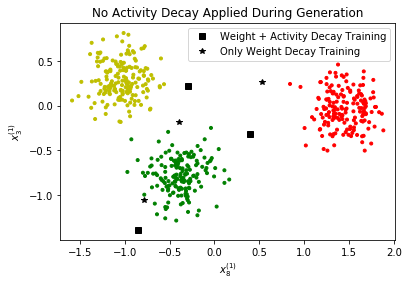

In [540]:
lgnd = ['Weight + Activity Decay Training', 'Only Weight Decay Training'] #['NoWD NoAD', 'YesWD NoAD', 'YesWD YesAD']

idx=(8,3)
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=idx)
plt.plot(np.array(zz2[:,idx[0]].cpu()), np.array(zz2[:,idx[1]].cpu()), 'ks');
plt.plot(np.array(zz3[:,idx[0]].cpu()), np.array(zz3[:,idx[1]].cpu()), 'k*');
plt.xlabel('$x_8^{(1)}$')
plt.ylabel('$x_3^{(1)}$')
plt.legend(lgnd)
plt.title('No Activity Decay Applied During Generation')
plt.savefig("no_activity_decay_during_testing.pdf", format='pdf')

In [550]:
np.save('zz2.npy', zz2.cpu())
np.save('zz3.npy', zz3.cpu())

In [343]:
norm_corr_sum = 0
for i in range(0, trials):
    for j in range (0, 3): #3 = number of classes
        norm_corr_sum += np.dot(z2[j].cpu(), A[j]) / (np.linalg.norm(z2[j].cpu())*np.linalg.norm(A[j]))
        
print(norm_corr_sum / 3*trials)

69.74620041685912


In [344]:
norm_corr_sum = 0
for i in range(0, trials):
    for j in range (0, 3): #3 = number of classes
        norm_corr_sum += np.dot(z3[j].cpu(), A[j]) / (np.linalg.norm(z3[j].cpu())*np.linalg.norm(A[j]))
        
print(norm_corr_sum / 3*trials)

69.17001339867413
